In [1]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight

# Dataset Loading

In [2]:
os.listdir('./train')

['Mild', 'Moderate', 'Proliferate_DR', 'Severe', 'No_DR']

In [3]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('./train'):
  train_class = os.listdir(os.path.join('train', i))
  for j in train_class:
    img = os.path.join('train', i, j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))

Number of train images : 3662 



The diabetic retinopathy dataset comprises retinal images categorized into five classes: Mild, Moderate, Proliferate_DR, Severe, and No_DR. These classes represent different stages of diabetic retinopathy, ranging from early signs to severe complications, as well as images without any diabetic retinopathy.

# DATA EXPLORATION AND DATA VISUALIZATION

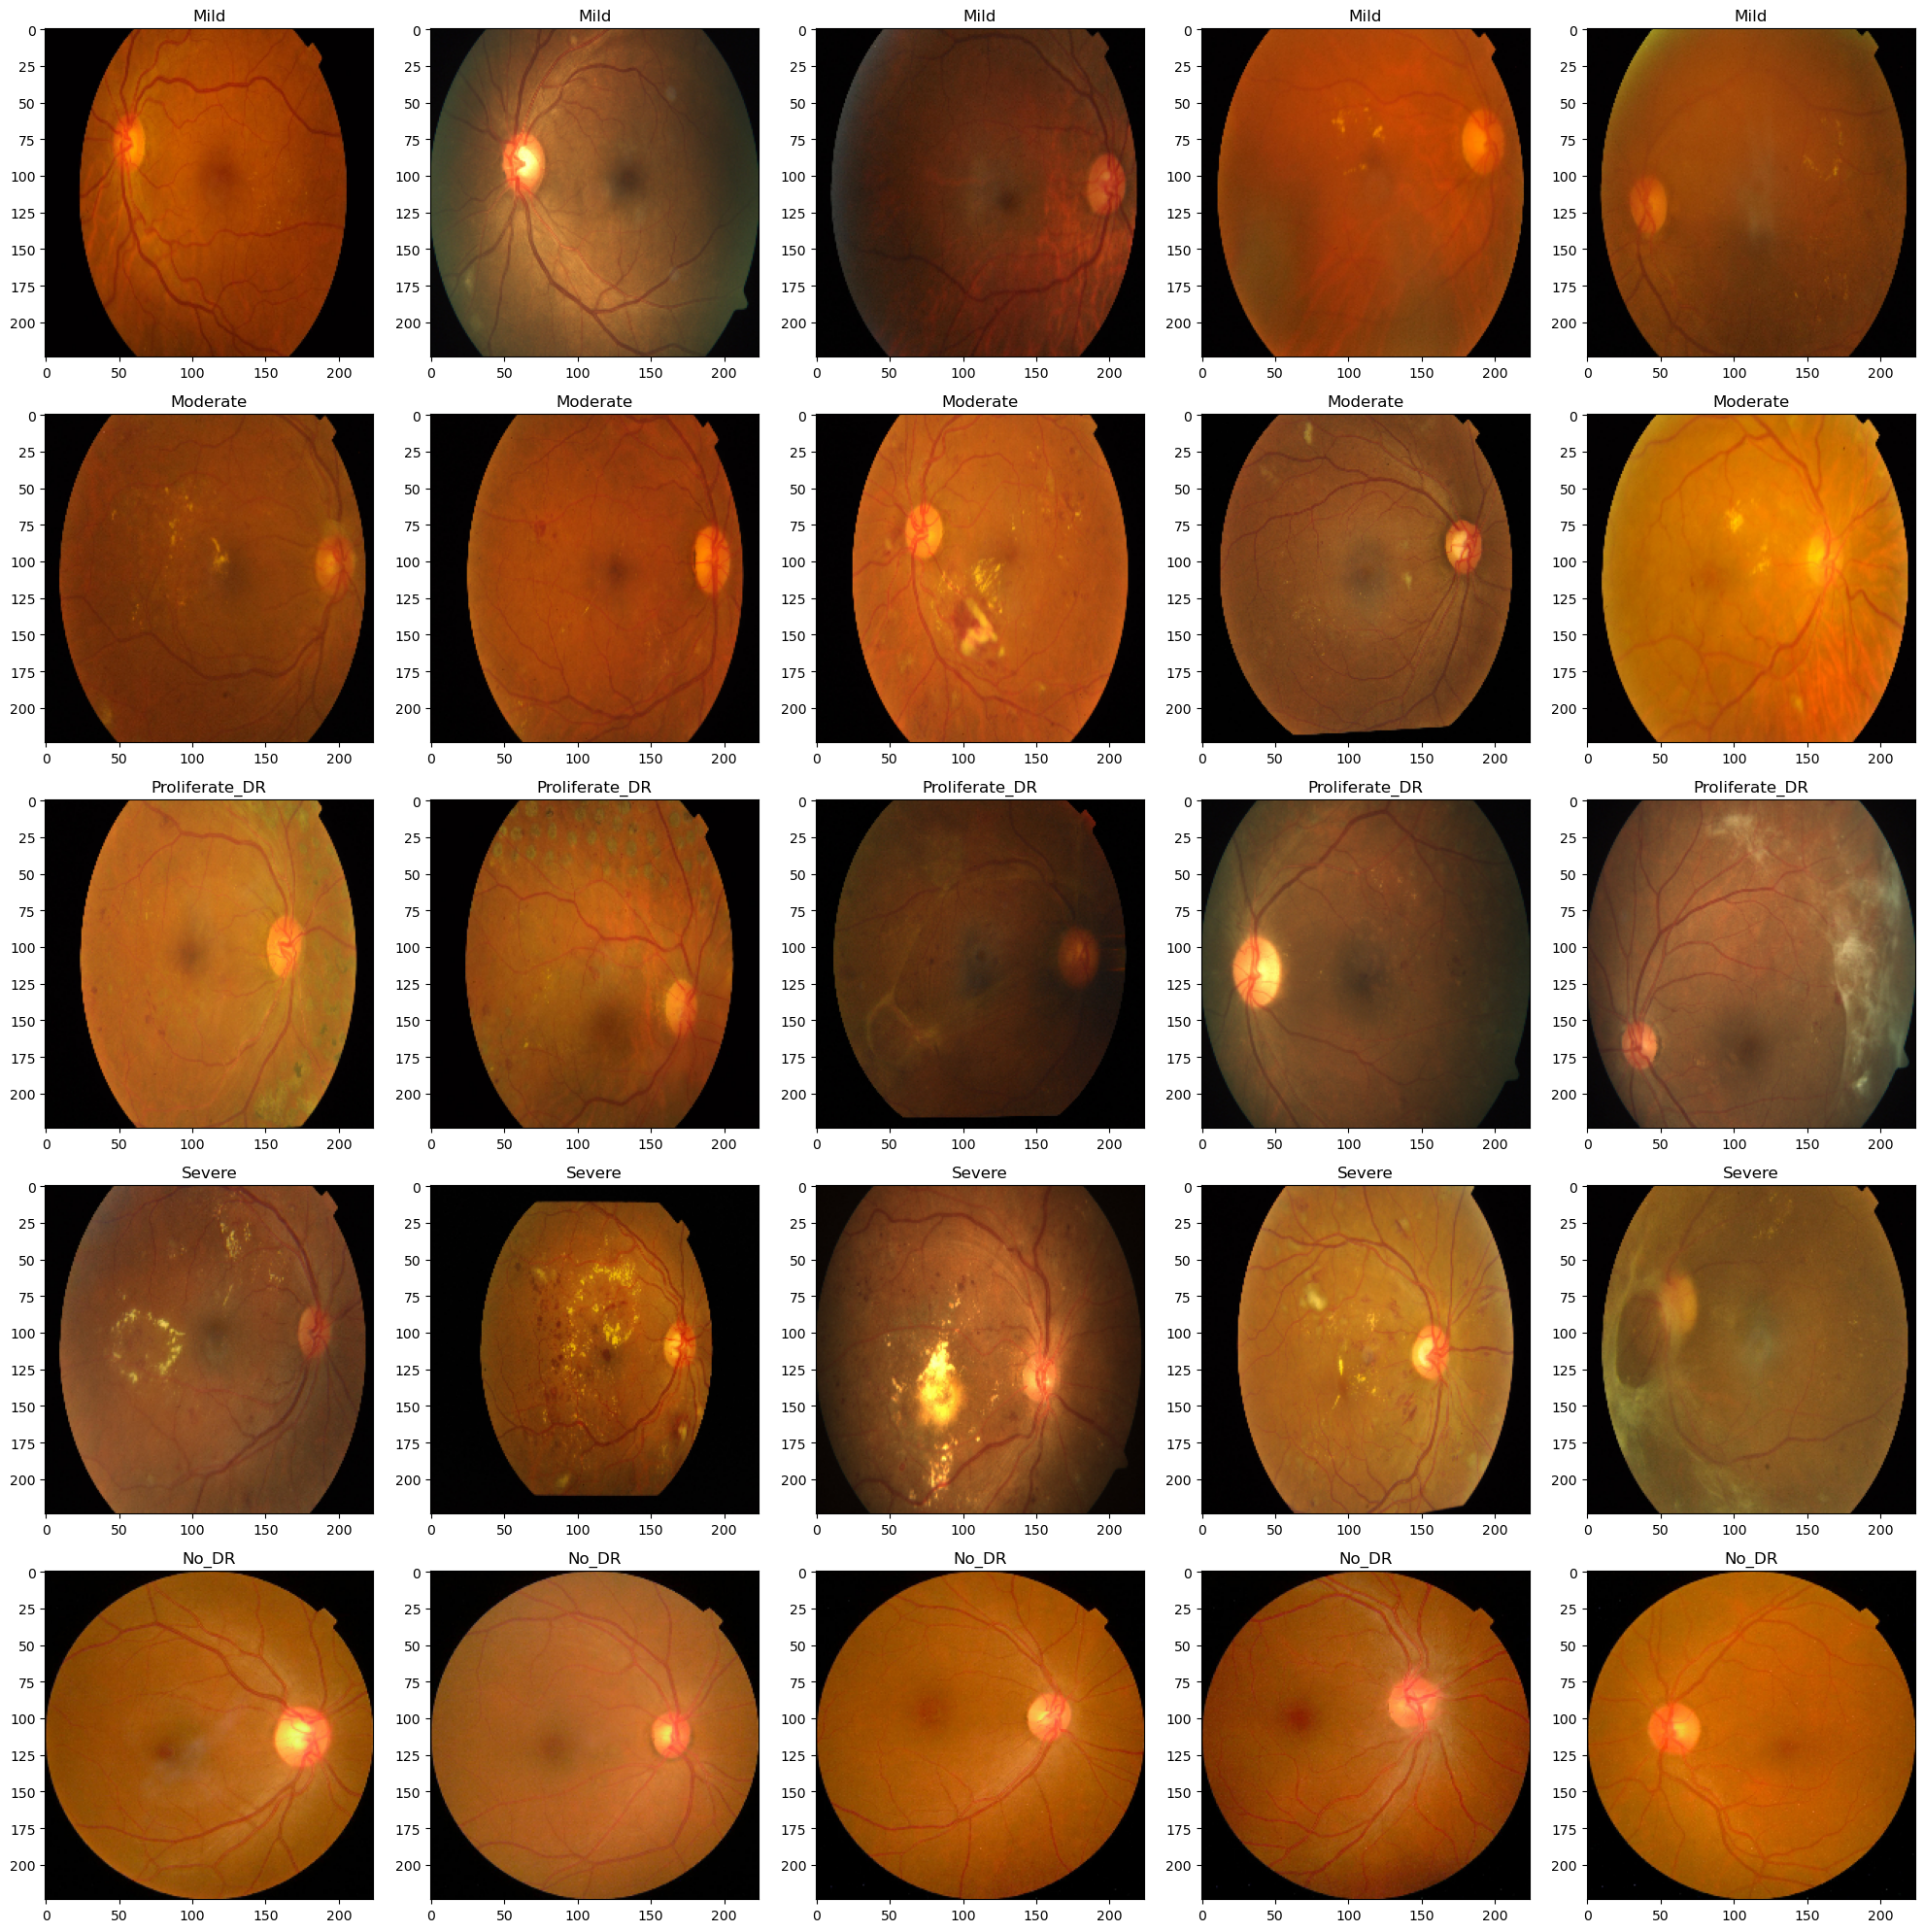

In [4]:
# Visualize 5 images for each class in the dataset

fig, axs = plt.subplots(5, 5, figsize = (20, 20))
count = 0
for i in os.listdir('./train'):
  # get the list of images in a given class
  train_class = os.listdir(os.path.join('train', i))
  # plot 5 images per class
  for j in range(5):
    img = os.path.join('train', i, train_class[j])
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1

fig.tight_layout()


# Steps of Image Preprocessing:
Step-1: All the images contains black background. And we can observe some of the images have extra dark pixels at the sides of the images. So in step-1 involves cropping of those extra dark pixels.
Step-2: We can see that their is no fixed size for image width and image height. Hence we do resizing of an image in step-2.
Step-3: Lot of images are shrinked and some images have circular shape and some are cropped at edges. Hence in step-3 we are drawing a circle from the center to give a similar shape to all the images.
Step-4: As we can observe most of the images are taken in different resolutions. Where some are taken in lighting conditions and some in dark. we are adding a smoothing technique in order to remove the noise in images by using gaussian blur to the images. This gives our final preprocessed image

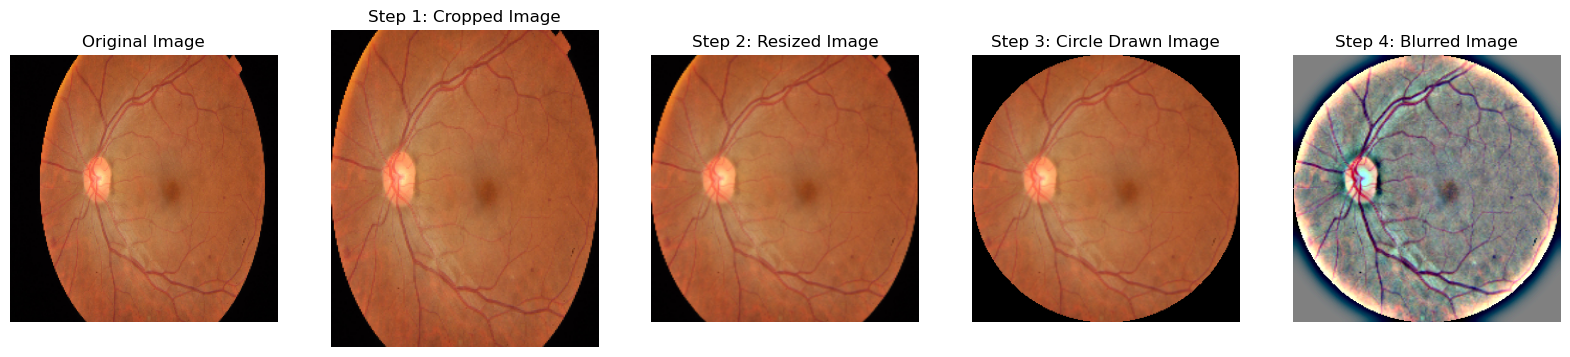

In [5]:
# Sample preprocessing of Image
class ImageProcessing:
    def __init__(self, img_height, img_width, no_channels, tol=7, sigmaX=8):
        self.img_height = img_height
        self.img_width = img_width
        self.no_channels = no_channels
        self.tol = tol
        self.sigmaX = sigmaX

    def cropping_2D(self, img, is_cropping=False):
        mask = img > self.tol
        return img[np.ix_(mask.any(1), mask.any(0))]

    def cropping_3D(self, img, is_cropping=False):
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > self.tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

    def Gaussian_blur(self, img, is_gaussianblur=False):
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), self.sigmaX), -4, 128)
        return img

    def draw_circle(self, img, is_drawcircle=True):
        x = int(self.img_width / 2)
        y = int(self.img_height / 2)
        r = np.amin((x, y))
        circle_img = np.zeros((self.img_height, self.img_width), np.uint8)
        cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        return img

    def image_preprocessing(self, img, is_cropping=True, is_gaussianblur=True):
        if img.ndim == 2:
            img = self.cropping_2D(img, is_cropping)
        else:
            img = self.cropping_3D(img, is_cropping)
        img = cv2.resize(img, (self.img_width, self.img_height))
        img = self.draw_circle(img)
        img = self.Gaussian_blur(img, is_gaussianblur)
        return img

def display_stepwise_preprocessing(original_img, processed_imgs, titles):
    num_steps = len(processed_imgs) + 1
    
    plt.figure(figsize=(20, 6))
    
    # Display original image
    plt.subplot(1, num_steps, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    # Display each processed image
    for i in range(len(processed_imgs)):
        plt.subplot(1, num_steps, i + 2)
        plt.imshow(cv2.cvtColor(processed_imgs[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    
    plt.show()

# Example usage
obj1 = ImageProcessing(img_height=256, img_width=256, no_channels=3, tol=7, sigmaX=8)

# Load and preprocess image
img_path = './train/Moderate/0e75d51152fc.png'
img = cv2.imread(img_path)

# Step 1: Crop extra dark pixels
cropped_img = obj1.cropping_3D(img)
step1_title = "Step 1: Cropped Image"

# Step 2: Resize image
resized_img = cv2.resize(cropped_img, (obj1.img_width, obj1.img_height))
step2_title = "Step 2: Resized Image"

# Step 3: Draw circle
circle_img = obj1.draw_circle(resized_img)
step3_title = "Step 3: Circle Drawn Image"

# Step 4: Apply Gaussian blur
blurred_img = obj1.Gaussian_blur(circle_img)
step4_title = "Step 4: Blurred Image"

# Display step-wise preprocessing
processed_imgs = [cropped_img, resized_img, circle_img, blurred_img]
titles = [step1_title, step2_title, step3_title, step4_title]
display_stepwise_preprocessing(img, processed_imgs, titles)


In [6]:
retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df

Image Labels
0      train/Mild/2d7666b8884f.png   Mild
1      train/Mild/50840c36f0b4.png   Mild
2      train/Mild/30cab14951ac.png   Mild
3      train/Mild/a8582e346df0.png   Mild
4      train/Mild/cab3dfa7962d.png   Mild
...                            ...    ...
3657  train/No_DR/6b30767595d8.png  No_DR
3658  train/No_DR/2b4c7b5f1f1e.png  No_DR
3659  train/No_DR/ab78a66dee6a.png  No_DR
3660  train/No_DR/79ade634c633.png  No_DR
3661  train/No_DR/7a77c3eb468c.png  No_DR

[3662 rows x 2 columns]

Number of images in Mild = 370
Number of images in Moderate = 999
Number of images in Proliferate_DR = 295
Number of images in Severe = 193
Number of images in No_DR = 1805


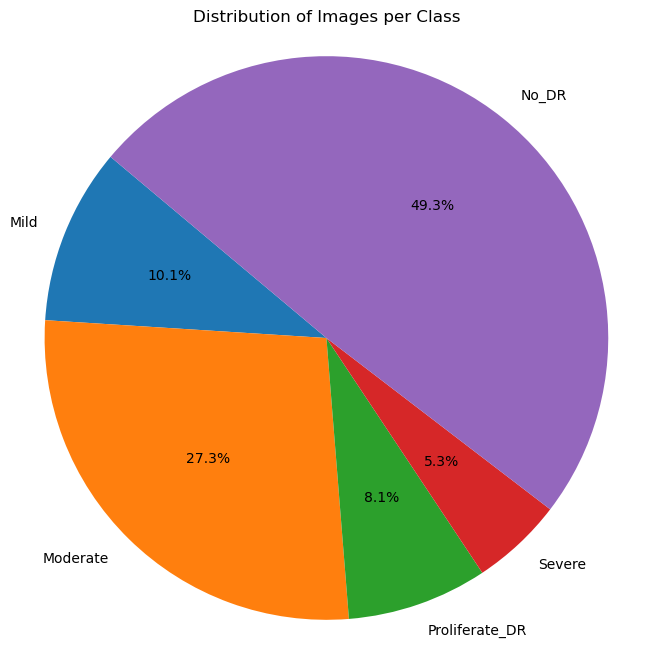

In [7]:
# check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

# Assuming the images are stored in subdirectories of './train'
for i in os.listdir('./train'):
    train_class = os.listdir(os.path.join('./train', i))
    No_images_per_class.append(len(train_class))
    Class_name.append(i)
    print('Number of images in {} = {}'.format(i, len(train_class)))

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(No_images_per_class, labels=Class_name, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
